In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import seaborn as sns
import tkinter as tk
from tkinter import ttk
from datetime import date, time, datetime, timedelta
from IPython.display import clear_output
import scipy.stats
from statistics import mode

In [2]:
laptop = 'home'

if laptop == 'home':
    growth_data_path = "C:/Users/tmccl/OneDrive/Documents/GitHub/AFL-Leek-Growth-Model/growth_db.csv"
    weather_data_path = "C:/Users/tmccl/OneDrive/Documents/GitHub/AFL-Leek-Growth-Model/weather_db.csv"
    zone_data_path = "C:/Users/tmccl/OneDrive/Documents/GitHub/AFL-Leek-Growth-Model/zone_db.csv"
    
if laptop == 'work':
    growth_data_path = "F:\\Farm Data\Growth Model\growth_db.csv"
    weather_data_path = "F:\\Farm Data\Growth Model\weather_db.csv"
    zone_data_path = "F:\\Farm Data\Growth Model\\zone_db.csv"
    
growth_data = pd.read_csv(growth_data_path)
weather_data = pd.read_csv(weather_data_path)
zone_data = pd.read_csv(zone_data_path)

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%d/%m/%Y')
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%H:%M:%S')
weather_data['day'] = weather_data.date.dt.day
weather_data['month'] = weather_data.date.dt.month
weather_data['day_month'] = weather_data['day'].astype(str) + " - " + weather_data['month'].astype(str)

min_grow_temp = 5

weather_data['heat_units'] = weather_data['avg_temp'] - min_grow_temp
weather_data['heat_units'] = np.where((weather_data['heat_units'] < 0), 0, weather_data['heat_units']/24)

In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63375 entries, 0 to 63374
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             63375 non-null  datetime64[ns]
 1   time             63375 non-null  datetime64[ns]
 2   avg_temp         63375 non-null  float64       
 3   rh               63375 non-null  float64       
 4   rain             63375 non-null  float64       
 5   solar_radiation  63375 non-null  float64       
 6   wind_speed_avg   63375 non-null  float64       
 7   wind_speed_gust  7143 non-null   float64       
 8   soil_temp        7143 non-null   float64       
 9   bat_volt         63375 non-null  float64       
 10  leaf_wet         60962 non-null  float64       
 11  dew_point        60962 non-null  float64       
 12  day              63375 non-null  int64         
 13  month            63375 non-null  int64         
 14  day_month        63375 non-null  objec

In [6]:
weather_data.head()

date                time  avg_temp    rh  rain  solar_radiation  \
0 2014-05-14 1900-01-01 14:00:00      16.2  55.9   0.0            457.0   
1 2014-05-14 1900-01-01 15:00:00      17.4  51.2   0.0           1212.0   
2 2014-05-14 1900-01-01 16:00:00      17.7  48.9   0.0            862.0   
3 2014-05-14 1900-01-01 17:00:00      17.9  48.9   0.0            611.0   
4 2014-05-14 1900-01-01 18:00:00      17.2  51.0   0.0            232.0   

   wind_speed_avg  wind_speed_gust  soil_temp  bat_volt  leaf_wet  dew_point  \
0             2.7              NaN        NaN    6904.0       0.0        7.2   
1             2.2              NaN        NaN    6952.0       0.0        7.0   
2             2.1              NaN        NaN    6922.0       0.0        6.6   
3             2.0              NaN        NaN    6904.0       0.0        6.7   
4             1.7              NaN        NaN    6894.0       0.0        6.7   

   day  month day_month  heat_units  
0   14      5    14 - 5    0.466667  
1   14      5    14 - 5    0.516667  
2   14      5    14 - 5    0.529167  
3   14      5    14 - 5    0.537500  
4   14      5    14 - 5    0.508333

In [7]:
growth_data['sample_date'] = pd.to_datetime(growth_data['sample_date'], format='%d/%m/%Y')
growth_data['fieldzone'] = growth_data["field"] + growth_data["zone"].astype(str)

stripping_coef = 0.92

growth_data['stripped_diameter'] = growth_data['diameter'] * stripping_coef

summary_data = growth_data

In [8]:
growth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96868 entries, 0 to 96867
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_date        96868 non-null  datetime64[ns]
 1   field              96868 non-null  object        
 2   zone               96868 non-null  int64         
 3   diameter           96868 non-null  float64       
 4   fieldzone          96868 non-null  object        
 5   stripped_diameter  96868 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 4.4+ MB


In [9]:
growth_data.head()

sample_date      field  zone  diameter   fieldzone  stripped_diameter
0  2019-07-17  Allans 18     1       4.0  Allans 181               3.68
1  2019-07-17  Allans 18     1       3.0  Allans 181               2.76
2  2019-07-17  Allans 18     1       5.0  Allans 181               4.60
3  2019-07-17  Allans 18     1       5.0  Allans 181               4.60
4  2019-07-17  Allans 18     1       3.0  Allans 181               2.76

In [10]:
zone_data['planting_date'] = pd.to_datetime(zone_data['planting_date'], format='%d/%m/%Y')
zone_data['est_harvest_date'] = pd.to_datetime(zone_data['est_harvest_date'], format='%d/%m/%Y')
zone_data['zone'] = zone_data['zone'].astype(int)
zone_data["fieldzone"] = zone_data["field"] + zone_data["zone"].astype(str)

In [11]:
zone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   field             688 non-null    object        
 1   zone              688 non-null    int32         
 2   planting_date     688 non-null    datetime64[ns]
 3   variety           688 non-null    object        
 4   method            688 non-null    object        
 5   inputs            688 non-null    object        
 6   protection        688 non-null    object        
 7   planting_rate     688 non-null    int64         
 8   sand              688 non-null    int64         
 9   silt              688 non-null    int64         
 10  clay              688 non-null    int64         
 11  organic_matter    688 non-null    float64       
 12  est_harvest_date  688 non-null    datetime64[ns]
 13  fieldzone         688 non-null    object        
dtypes: datetime64[ns](2), floa

In [12]:
zone_data.head()

field  zone planting_date  variety   method        inputs protection  \
0  Allans 07     1    2019-04-01  Krypton  Drilled  Conventional     Barley   
1  Allans 07     2    2019-04-01  Krypton  Drilled  Conventional     Barley   
2  Allans 07     3    2019-04-01  Longton  Drilled  Conventional     Barley   
3  Allans 07     4    2019-04-01  Longton  Drilled  Conventional     Barley   
4  Allans 07     5    2019-04-01   Batter  Drilled  Conventional     Barley   

   planting_rate  sand  silt  clay  organic_matter est_harvest_date  \
0         249820    39    37    24            29.6       2019-12-15   
1         249820    39    37    24            29.6       2019-12-15   
2         256524    39    37    24            29.6       2019-12-15   
3         256524    39    37    24            29.6       2019-12-15   
4         247048    39    37    24            29.6       2019-12-15   

    fieldzone  
0  Allans 071  
1  Allans 072  
2  Allans 073  
3  Allans 074  
4  Allans 075

In [13]:
summary_data["zone"] = summary_data["zone"].astype(str)
summary_data["fieldzone"] = summary_data["field"] + summary_data["zone"]
summary_data['fieldzonedate'] = summary_data['fieldzone'] + summary_data['sample_date'].astype(str)

summary_data = summary_data.set_index('fieldzone')
summary_data = summary_data.join(zone_data.set_index('fieldzone'), rsuffix = '_join')

summary_data['heat_units'] = 0
summary_data['solar_radiation'] = 0

summary_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96868 entries, Allans 061 to Wissey O (S)3
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_date        96868 non-null  datetime64[ns]
 1   field              96868 non-null  object        
 2   zone               96868 non-null  object        
 3   diameter           96868 non-null  float64       
 4   stripped_diameter  96868 non-null  float64       
 5   fieldzonedate      96868 non-null  object        
 6   field_join         96250 non-null  object        
 7   zone_join          96250 non-null  float64       
 8   planting_date      96250 non-null  datetime64[ns]
 9   variety            96250 non-null  object        
 10  method             96250 non-null  object        
 11  inputs             96250 non-null  object        
 12  protection         96250 non-null  object        
 13  planting_rate      96250 non-null  float64       

In [14]:
summary_data = summary_data.reset_index(inplace=False)
summary_data = summary_data.drop(columns=['field_join', 'zone_join'], inplace=False)

In [15]:
def cum_heat_units(start, finish, weather_data):
    df = weather_data.loc[(weather_data['date'] > start) & (weather_data['date'] < finish), ['heat_units']]
    total_hu = df['heat_units'].sum()
    return total_hu

def cum_solar_radiation(start, finish, weather_data = weather_data):
    df = weather_data.loc[(weather_data['date'] > start) & (weather_data['date'] < finish), ['solar_radiation']]
    total_sr = df['solar_radiation'].sum()
    return total_sr

In [16]:
summary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96868 entries, 0 to 96867
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fieldzone          96868 non-null  object        
 1   sample_date        96868 non-null  datetime64[ns]
 2   field              96868 non-null  object        
 3   zone               96868 non-null  object        
 4   diameter           96868 non-null  float64       
 5   stripped_diameter  96868 non-null  float64       
 6   fieldzonedate      96868 non-null  object        
 7   planting_date      96250 non-null  datetime64[ns]
 8   variety            96250 non-null  object        
 9   method             96250 non-null  object        
 10  inputs             96250 non-null  object        
 11  protection         96250 non-null  object        
 12  planting_rate      96250 non-null  float64       
 13  sand               96250 non-null  float64       
 14  silt  

In [17]:
summary_data_avg = summary_data.groupby(['fieldzonedate']).agg({'stripped_diameter' : ['mean', 'std', 'count'],
                                                                'method' : ['first'],
                                                                'inputs' : ['first'],
                                                                'variety' : ['first'],
                                                                'protection' : ['first'],
                                                                'sand' : ['mean'],
                                                                'silt' : ['mean'],
                                                                'clay' : ['mean'],
                                                                'organic_matter' : ['mean'],
                                                                'planting_date' : ['first'],
                                                                'sample_date' : ['first'],
                                                                'fieldzone' : ['first']}).reset_index()

summary_data_avg.columns = ['fieldzonedate',
                            'mean_diameter',
                            'std_dev_diameter',
                            'pp2m2', 
                            'method',
                            'inputs',
                            'variety',
                            'protection',
                            'sand',
                            'silt',
                            'clay',
                            'organic_matter',
                            'planting_date',
                            'sample_date',
                            'fieldzone']

summary_data_avg['d_lin'] = (summary_data_avg['mean_diameter'])**0.625
summary_data_avg['s_lin'] = (summary_data_avg['std_dev_diameter'])**0.625
summary_data_avg['heat_units'] = 0
summary_data_avg['solar_radiation'] = 0

summary_data_avg.head()

fieldzonedate  mean_diameter  std_dev_diameter  pp2m2   method  \
0  Allans 0612021-07-29       9.175789          3.043690     38  Drilled   
1  Allans 0622021-07-29       9.532766          2.835147     47  Drilled   
2  Allans 0632021-07-29       8.034667          3.085150     45  Drilled   
3  Allans 0642021-07-29       8.168485          3.109321     33  Drilled   
4  Allans 0652021-07-29       6.483810          2.289451     42  Drilled   

         inputs  variety protection  sand  silt  clay  organic_matter  \
0  Conventional  Krypton     Barley  40.0  41.0  19.0            24.6   
1  Conventional  Krypton     Barley  40.0  41.0  19.0            24.6   
2  Conventional  Krypton     Barley  40.0  41.0  19.0            24.6   
3  Conventional  Krypton     Barley  40.0  41.0  19.0            24.6   
4  Conventional  Krypton     Barley  40.0  41.0  19.0            24.6   

  planting_date sample_date   fieldzone     d_lin     s_lin  heat_units  \
0    2021-04-10  2021-07-29  Allans 061  3.996245  2.005050           0   
1    2021-04-10  2021-07-29  Allans 062  4.092718  1.918049           0   
2    2021-04-10  2021-07-29  Allans 063  3.677942  2.022077           0   
3    2021-04-11  2021-07-29  Allans 064  3.716109  2.031964           0   
4    2021-04-11  2021-07-29  Allans 065  3.216577  1.678155           0   

   solar_radiation  
0                0  
1                0  
2                0  
3                0  
4                0

In [18]:
weather_data_avg = weather_data.groupby(['date']).agg({'rain' : ['sum'],
                                                       'heat_units' : ['sum'],
                                                       'solar_radiation' : ['sum'],
                                                       'wind_speed_avg' : ['mean'],
                                                       'rh' : ['mean'],
                                                       'avg_temp' : ['mean']}).reset_index()

weather_data_avg.columns = ['date',
                            'rain',
                            'heat_units',
                            'solar_radiation',
                            'wind_speed_avg',
                            'rh',
                            'avg_temp']

weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)  

weather_data_avg_group = weather_data_avg.groupby(['day_month']).agg({'rain' : ['mean'],
                                                                      'heat_units' : ['mean'],
                                                                      'solar_radiation' : ['mean'],
                                                                      'wind_speed_avg' : ['mean'],
                                                                      'rh' : ['mean'],
                                                                      'avg_temp' : ['mean']}).reset_index()
weather_data_avg_group.columns = ['day_month',
                                  'rain',
                                  'heat_units',
                                  'solar_radiation',
                                  'wind_speed_avg',
                                  'rh',
                                  'avg_temp']

max_date = max(weather_data_avg.date)

for i in range(1, 500):
    
    clear_output(wait=True)
    
    date = max_date + timedelta(days=i)
    weather_data_avg = weather_data_avg.append({'date': date,
                                                'rain': np.nan,
                                                'heat_units':np.nan,
                                                'solar_radiation':np.nan,
                                                'wind_speed_avg':np.nan,
                                                'rh':np.nan,
                                                'avg_temp':np.nan }, ignore_index=True)
    
    print("Current Progress:", np.round(i/500*100,0),"%")
    
weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)  

Current Progress: 100.0 %


In [19]:
def mean_weather(day_month, variable):
    
    df = weather_data_avg_group[weather_data_avg_group['day_month']==day_month]
    weather_value = df[variable].sum()
    return weather_value

for variable in ['rain', 'heat_units', 'solar_radiation', 'wind_speed_avg', 'rh', 'avg_temp']:
    for i in weather_data_avg.index:
        clear_output(wait=True)
        if weather_data_avg[variable][i] == np.nan:
            test = 'test'
        else:
            day_month = weather_data_avg['day_month'][i]
            weather_data_avg[variable][i] = mean_weather(day_month, variable)
        print(f"{variable} progress:", np.round(i/len(weather_data_avg)*100,0),"%")
    
weather_data_avg

avg_temp progress: 100.0 %


date       rain  heat_units  solar_radiation  wind_speed_avg  \
0    2014-05-14   0.825000    4.829687      9217.820000        4.122604   
1    2014-05-15   0.925000    6.291146     11512.520000        3.593802   
2    2014-05-16   0.425000    7.422917      9943.060000        4.079896   
3    2014-05-17   4.650000    7.288021      9964.665000        3.792969   
4    2014-05-18   5.850000    7.395313     10198.580000        3.074792   
5    2014-05-19   0.875000    7.941146     11232.215000        3.850104   
6    2014-05-20   0.825000    8.527604     10693.015000        5.160990   
7    2014-05-21   0.525000    9.027083     11017.475000        8.278646   
8    2014-05-22   1.675000    8.840625     11270.720000        4.674531   
9    2014-05-23   0.450000    8.075000     11287.270000        5.625417   
10   2014-05-24   2.275000    8.179688     10252.590000        4.455833   
11   2014-05-25   0.000000    8.406250      9961.955000        4.786094   
12   2014-05-26   0.050000    9.231250     10688.685000        4.330312   
13   2014-05-27   3.950000    9.403646     10705.695000        3.724479   
14   2014-05-28   1.350000    8.879167     10533.250000        2.861875   
15   2014-05-29   1.700000    8.322396      9161.865000        3.753854   
16   2014-05-30   0.050000    9.083854      9663.945000        4.837917   
17   2014-05-31   3.950000    9.355729      9459.030000        4.417917   
18   2014-06-01   0.400000   10.521354     11261.765000        4.044167   
19   2014-06-02   0.800000   10.986458      9338.925000        4.710729   
20   2014-06-03   0.300000    9.895312      9973.485000        3.026406   
21   2014-06-04   2.025000    8.048437      7797.465000        3.726823   
22   2014-06-05   1.100000    9.013542     10164.325000        2.964115   
23   2014-06-06   2.625000    8.528646     11540.495000        2.767031   
24   2014-06-07   2.075000    9.533333     10508.750000        3.380521   
25   2014-06-08   0.500000    9.499479     10507.620000        2.761823   
26   2014-06-09   0.125000    9.582812     11075.940000        2.899010   
27   2014-06-10   2.250000    9.892188      9391.565000        3.502760   
28   2014-06-11   1.250000   10.702604     10717.525000        4.509323   
29   2014-06-12   1.250000   10.613021      9477.655000        3.659792   
30   2014-06-13   1.750000   11.009896     10095.180000        2.397396   
31   2014-06-14   1.075000   11.347917      9506.890000        4.221562   
32   2014-06-15   0.225000   10.392188     12014.545000        2.865104   
33   2014-06-16   1.250000   10.777604     10205.630000        2.964062   
34   2014-06-17   2.050000   11.459375      9634.385000        3.728646   
35   2014-06-18   7.550000   10.885417      8641.240000        5.662812   
36   2014-06-19   0.800000   10.985937      8548.475000        3.539531   
37   2014-06-20   2.750000   11.304688      8851.315000        4.384219   
38   2014-06-21   0.200000   10.697396     11084.435000        5.183958   
39   2014-06-22   2.037500   10.257292     10174.560000        5.103385   
40   2014-06-23   2.462500   11.171354     10612.765000        2.514323   
41   2014-06-24   0.587500   12.552604     11151.445000        2.699219   
42   2014-06-25   1.462500   12.029167     10364.580000        3.911979   
43   2014-06-26   0.512500   11.611458     11428.085000        4.907812   
44   2014-06-27   5.825000   11.040625      9533.070000        5.702708   
45   2014-06-28   5.725000    9.947396      8344.095000        4.562812   
46   2014-06-29   1.450000   10.526042      9233.205000        4.496823   
47   2014-06-30   0.200000   11.420312     11026.275000        4.181927   
48   2014-07-01   0.550000   12.141667     11067.635000        3.625365   
49   2014-07-02   0.025000   11.679167     12443.735000        2.707135   
50   2014-07-03   0.300000   11.978125     12028.410000        2.762656   
51   2014-07-04   3.250000   13.053646     11558.690000        3.098229   
52   2014-07-05   0.950000   12.8125

In [20]:
for i in summary_data_avg.index:
    clear_output(wait=True)
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['heat_units'][i] = cum_heat_units(planting_date, sample_date, weather_data_avg)
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


In [21]:
for i in summary_data_avg.index:
    clear_output(wait=True)
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['solar_radiation'][i] = cum_solar_radiation(planting_date, sample_date, weather_data_avg)
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


<AxesSubplot:xlabel='s_lin', ylabel='solar_radiation'>

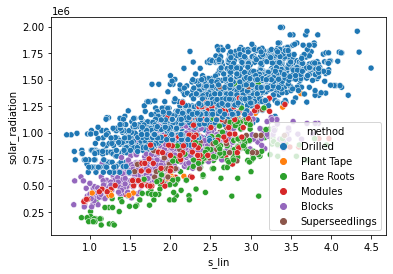

In [22]:
summary_data_avg = summary_data_avg.dropna()
sns.scatterplot(data = summary_data_avg, x = 's_lin', y = 'solar_radiation', hue = 'method')

In [23]:
summary_data_avg = pd.get_dummies(summary_data_avg, columns = ['protection'], drop_first = True)

In [24]:
X = summary_data_avg.drop(['d_lin',
                           'mean_diameter',
                           'std_dev_diameter',
                           'fieldzonedate',
                           'sample_date',
                           'planting_date',
                           'sand',
                           'silt',
                           'clay',
                           'fieldzone'], axis = 1)

y = summary_data_avg['d_lin']

In [25]:
X = pd.get_dummies(X, columns = ['method',
                                 'inputs',
                                 'variety'], drop_first = True)

In [26]:
summary_data_avg.loc[(summary_data_avg.solar_radiation == 0)]

Empty DataFrame
Columns: [fieldzonedate, mean_diameter, std_dev_diameter, pp2m2, method, inputs, variety, sand, silt, clay, organic_matter, planting_date, sample_date, fieldzone, d_lin, s_lin, heat_units, solar_radiation, protection_Fleece, protection_None, protection_Poly]
Index: []

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

X_scaled = X

#scaler.fit_transform(X)

reg = LinearRegression().fit(X_scaled, y)
preds = reg.predict(X_scaled)
summary_data_avg['preds'] = preds
reg.score(X_scaled, y)

0.9096395865485032

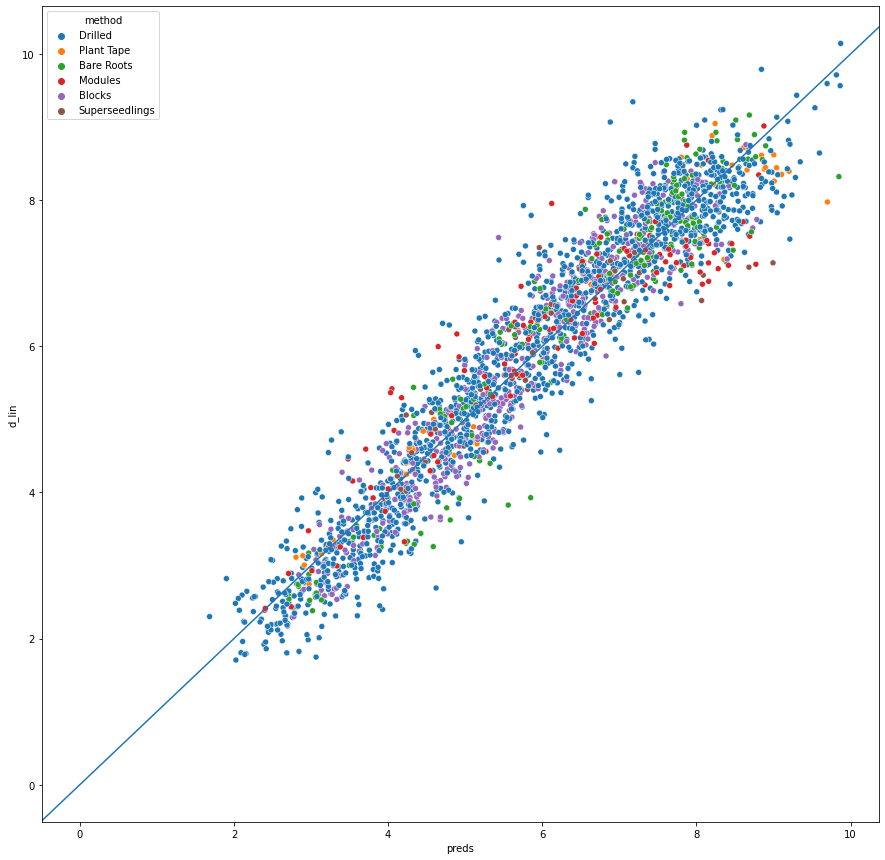

In [28]:
plt.figure(figsize=(15,15))
sns.scatterplot(x = 'preds', y = 'd_lin', data = summary_data_avg, hue = 'method')
plt.axline([0, 0], [1, 1])
plt.show()


In [29]:
coef_list = list(reg.coef_)
var_list = list(X)

reg_coef_df = pd.DataFrame({'variable': var_list,
                            'coef': coef_list}, columns=['variable',
                                                         'coef'])

reg_coef_df

variable      coef
0                   pp2m2  0.006338
1          organic_matter  0.016216
2                   s_lin  0.852715
3              heat_units  0.000856
4         solar_radiation  0.000003
5       protection_Fleece  0.581782
6         protection_None  0.219495
7         protection_Poly  0.979520
8           method_Blocks -1.300729
9          method_Drilled -3.392067
10         method_Modules -0.032571
11      method_Plant Tape -1.080286
12  method_Superseedlings -0.696075
13    inputs_Conventional  0.742490
14         inputs_Organic -0.103656
15         variety_Batter  0.091450
16         variety_Belton  0.221035
17       variety_Chiefton  0.047620
18       variety_Comanche  0.505944
19       variety_Defender  0.149364
20         variety_Fencer  0.464118
21        variety_Galvani  0.014750
22         variety_Gostar  0.326967
23        variety_Harston  0.104857
24        variety_Krypton  0.174377
25      variety_Lancaster  0.402019
26         variety_Lexton  0.025399
27       variety_Likestar -0.215102
28        variety_Linkton  0.694771
29        variety_Longton -0.108371
30      variety_Nun 70406  0.109257
31           variety_Oslo  0.508599
32        variety_Pluston  0.226262
33         variety_Runner  0.554120
34        variety_Shafton  0.482790
35        variety_Spheros  0.200451
36      variety_Stromboli -0.367940
37        variety_Sumstar  0.568332
38         variety_Triton -0.643236

In [30]:
X_1 = summary_data_avg.drop(['d_lin',
                             'mean_diameter',
                             'std_dev_diameter',
                             'fieldzonedate',
                             'sample_date',
                             'planting_date',
                             'preds',
                             'sand',
                             'silt',
                             'clay',
                             'fieldzone'], axis = 1)

X_1['growth_units'] = X_1['solar_radiation']*X_1['heat_units']

X_1 = X_1.drop(['heat_units',
                'solar_radiation'], axis = 1)

y_1 = summary_data_avg['mean_diameter']

In [31]:
X_1 = pd.get_dummies(X_1, columns = ['method',
                                     'inputs',
                                     'variety'], drop_first = True)

In [32]:
X_1_scaled = X_1
#scaler.fit_transform(X_1)

reg = LinearRegression().fit(X_1_scaled, y_1)
preds = reg.predict(X_1_scaled)

summary_data_avg['preds'] = preds

reg.score(X_1_scaled, y_1)

0.8725138071362256

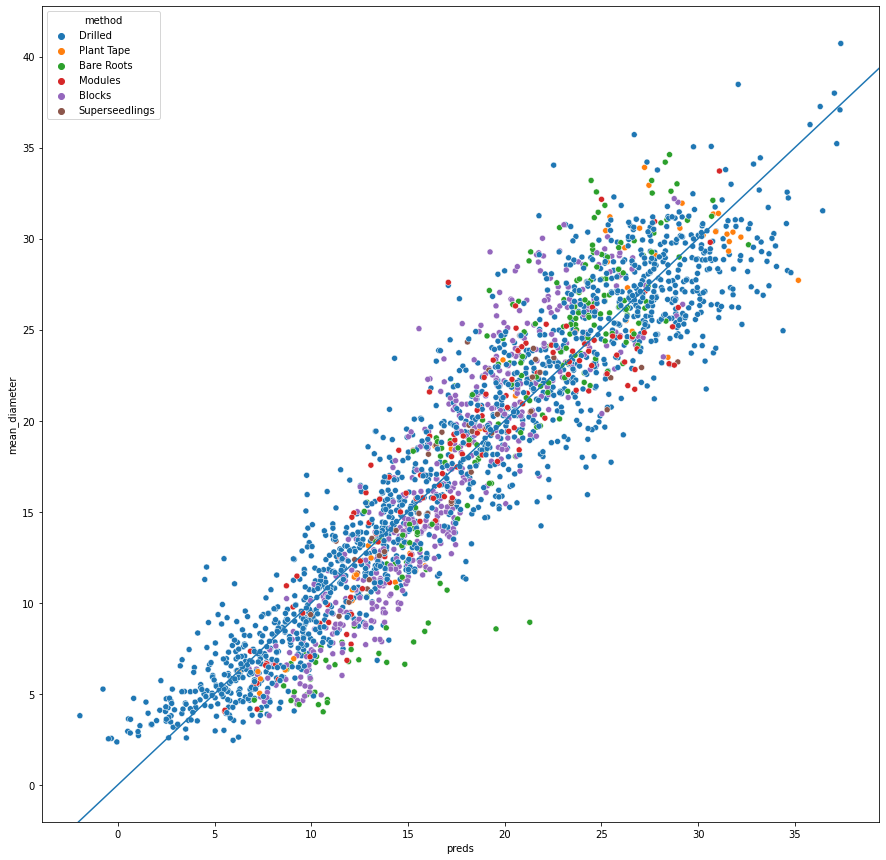

In [33]:
plt.figure(figsize=(15,15))
sns.scatterplot(x = 'preds', y = 'mean_diameter', data = summary_data_avg, hue = 'method')
plt.axline([0, 0], [1, 1])
plt.show()

In [34]:
coef_list = list(reg.coef_)
var_list = list(X_1)

reg_coef_df = pd.DataFrame({'variable': var_list, 'coef': coef_list}, columns=['variable', 'coef'])

reg_coef_df

variable          coef
0                   pp2m2  2.709359e-02
1          organic_matter  7.007308e-02
2                   s_lin  5.149248e+00
3       protection_Fleece  2.506954e+00
4         protection_None  7.255582e-01
5         protection_Poly  4.876150e+00
6            growth_units  5.734144e-09
7           method_Blocks -4.521964e+00
8          method_Drilled -1.089979e+01
9          method_Modules  7.886630e-02
10      method_Plant Tape -3.315028e+00
11  method_Superseedlings -3.101706e+00
12    inputs_Conventional  4.493305e+00
13         inputs_Organic  2.352279e+00
14         variety_Batter -1.200656e+00
15         variety_Belton -5.584428e-01
16       variety_Chiefton -1.856968e+00
17       variety_Comanche  1.143998e+00
18       variety_Defender -4.650002e-01
19         variety_Fencer  7.790013e-01
20        variety_Galvani -2.471011e+00
21         variety_Gostar -6.338512e-02
22        variety_Harston -3.591995e-01
23        variety_Krypton -7.440319e-01
24      variety_Lancaster -7.235224e-02
25         variety_Lexton -2.212668e+00
26       variety_Likestar -3.214112e+00
27        variety_Linkton  2.117966e+00
28        variety_Longton -2.214292e+00
29      variety_Nun 70406 -1.485916e+00
30           variety_Oslo  9.106815e-01
31        variety_Pluston  3.155711e-01
32         variety_Runner  1.613963e+00
33        variety_Shafton  9.799022e-01
34        variety_Spheros -2.209545e-01
35      variety_Stromboli -4.570149e+00
36        variety_Sumstar  2.074846e+00
37         variety_Triton -4.958435e+00

In [35]:
def average_count(fieldzone):
    
    df = summary_data_avg[summary_data_avg['fieldzone']==fieldzone]
    average_count = df['pp2m2'].mean()
    
    return average_count

average_count('Allans 071')

43.75

In [36]:
def max_sample_date(fieldzone):
    
    df = summary_data[summary_data['fieldzone']==fieldzone]
    max_sample_date = df['sample_date'].max()
    
    return max_sample_date

max_sample_date('Allans 071')

Timestamp('2020-01-13 00:00:00')

In [37]:
def max_mean_diameter_lin(fieldzone):
    
    df = summary_data_avg[summary_data_avg['fieldzone']==fieldzone]
    max_mean_diameter = df['mean_diameter'].max()
    max_mean_diameter_lin = max_mean_diameter ** 0.625
    
    return max_mean_diameter_lin

max_mean_diameter_lin('Allans 071')

9.26293214352213

In [38]:
def max_std_dev_diameter_lin(fieldzone):
    
    df = summary_data_avg[summary_data_avg['fieldzone']==fieldzone]
    max_std_dev_diameter = df['std_dev_diameter'].max()
    max_std_dev_diameter_lin = max_std_dev_diameter ** 0.625
    
    return max_std_dev_diameter_lin

max_std_dev_diameter_lin('Allans 071')

4.348294771174176

In [39]:
def max_solar(fieldzone):
    
    df = summary_data_avg[summary_data_avg['fieldzone']==fieldzone]
    max_solar = df['solar_radiation'].max()
    
    return max_solar

max_solar('Allans 071')

1760257

In [40]:
def max_heat(fieldzone):
    
    df = summary_data_avg[summary_data_avg['fieldzone']==fieldzone]
    max_heat = df['heat_units'].max()
    
    return max_heat

max_heat('Allans 071')

2084

In [41]:
zone_data['mean_pp2m2'] = 0.0
zone_data['max_sample_date'] = 0
zone_data['max_mean_diameter_lin'] = 0.0
zone_data['max_std_dev_diameter_lin'] = 0.0
zone_data['max_heat'] = 0.0
zone_data['max_solar'] = 0.0
zone_data['remaining_heat'] = 0.0
zone_data['remaining_solar'] = 0.0

for i in zone_data.index:
    
    clear_output(wait=True)
    
    fieldzone = zone_data.loc[i, 'fieldzone']
    zone_data.loc[i, 'mean_pp2m2'] = average_count(fieldzone)
    zone_data.loc[i, 'max_sample_date'] = max_sample_date(fieldzone)
    zone_data.loc[i, 'max_mean_diameter_lin'] = max_mean_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_std_dev_diameter_lin'] = max_std_dev_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_heat'] = max_heat(fieldzone)
    zone_data.loc[i, 'max_solar'] = max_solar(fieldzone)
    start = zone_data.loc[i, 'max_sample_date']
    finish = zone_data.loc[i, 'est_harvest_date']
    zone_data.loc[i, 'remaining_heat'] = cum_heat_units(start, finish, weather_data_avg)
    zone_data.loc[i, 'remaining_solar'] = cum_solar_radiation(start, finish, weather_data_avg)   
    
    print("Current Progress:", np.round(i/len(zone_data)*100,0),"%")

Current Progress: 100.0 %


In [42]:
zone_data = zone_data.dropna()
zone_data

field  zone planting_date    variety          method  \
0                  Allans 07     1    2019-04-01    Krypton         Drilled   
1                  Allans 07     2    2019-04-01    Krypton         Drilled   
2                  Allans 07     3    2019-04-01    Longton         Drilled   
3                  Allans 07     4    2019-04-01    Longton         Drilled   
4                  Allans 07     5    2019-04-01     Batter         Drilled   
5                  Allans 07     6    2019-04-01     Batter         Drilled   
6                  Allans 12     1    2020-05-02    Longton         Drilled   
7                  Allans 12     2    2020-05-02    Longton         Drilled   
8                  Allans 12     3    2020-05-02    Longton         Drilled   
9                  Allans 12     4    2020-05-02    Longton         Drilled   
10              Allans 16/17     1    2020-05-03     Lexton         Drilled   
11              Allans 16/17     2    2020-05-03     Batter         Drilled   
12              Allans 16/17     3    2020-05-03     Batter         Drilled   
13              Allans 16/17     4    2020-05-03   Chiefton         Drilled   
14              Allans 16/17     5    2020-05-05   Chiefton         Drilled   
15              Allans 16/17     6    2020-05-05     Lexton         Drilled   
16                 Allans 18     1    2019-04-23     Lexton         Drilled   
17                 Allans 18     2    2019-04-23     Lexton         Drilled   
18                 Allans 18     3    2019-04-23     Lexton         Drilled   
19                 Allans 18     4    2019-04-23     Lexton         Drilled   
20                 Allans 18     5    2019-04-23     Lexton         Drilled   
21                 Allans 18     6    2019-04-23     Lexton         Drilled   
22                 Allans 18     7    2019-04-23   Chiefton         Drilled   
23                 Allans 18     8    2019-04-23   Chiefton         Drilled   
28                 Angoods 1     1    2020-04-07    Krypton         Drilled   
29                 Angoods 1     2    2020-04-07    Krypton         Drilled   
30                 Angoods 1     3    2020-04-08    Krypton         Drilled   
31                 Angoods 1     4    2020-04-08    Krypton         Drilled   
32                 Angoods 1     5    2020-04-08    Krypton         Drilled   
33                 Angoods 1     6    2020-04-08    Krypton         Drilled   
34                 Angoods 1     7    2020-04-08    Krypton         Drilled   
35                 Angoods 4     1    2019-03-30   Chiefton         Drilled   
36                 Angoods 4     2    2019-03-30   Chiefton         Drilled   
37     Chatteris Farms 07/08     1    2020-05-27    Pluston      Plant Tape   
38     Chatteris Farms 07/08     2    2020-05-27    Pluston      Plant Tape   
39     Chatteris Farms 07/08     3    2020-05-28    Pluston      Plant Tape   
40     Chatteris Farms 07/08     4    2020-05-28    Pluston      Plant Tape   
41       Chatteris Farms 27A     1    2019-04-24     Triton         Drilled   
42       Chatteris Farms 27A     2    2019-04-24     Triton         Drilled   
43       Chatteris Farms 27A     3    2019-04-24     Triton         Drilled   
44       Chatteris Farms 27A     4    2019-04-24     Triton         Drilled   
45       Chatteris Farms 27B     1    2019-05-22    Pluston      Plant Tape   
46       Chatteris Farms 27B     2    2019-05-22    Pluston      Plant Tape   
47       Chatteris Farms 27B     3    2019-05-22    Pluston      Plant Tape   
48       Chatteris Farms 27B     4    2019-05-22    Pluston      Plant Tape   
49          Garretts Decoy 3     1    2019-03-25    Linkton         Drilled   
50          Garretts Decoy 3     2    2019-03-25    Linkton         Drilled   
51          Garretts Decoy 3     3    2019-03-25    Linkton         Drilled   
52          Garretts Decoy 3     4    2019-03-25    Linkton         Drilled   
53          Garretts Decoy 4     1    2020-04-26   Comanche         Drill

In [43]:
def filter_data(data, method, inputs, variety):
    
    filtered = data[data['variety'].str.contains(variety)]
    filtered = filtered[filtered['inputs'].str.contains(inputs)]
    filtered = filtered[filtered['method'].str.contains(method)]
    
    return filtered

In [44]:
def predict_weather(start, finish, variable):
    
    df = weather_data_avg.loc[(weather_data_avg['date'] > start) & (weather_data_avg['date'] < finish), [variable]]
    pred_hu = df[variable].sum()
    
    return pred_hu

start = datetime(year=2021, month=6, day=2, hour=13, minute=14, second=31)
finish = datetime(year=2022, month=6, day=2, hour=13, minute=14, second=31)

predict_weather(start, finish, 'rain')

577.1410714285714

In [45]:
zone_data['est_mean_diameter_gain'] = 0.0
zone_data['est_std_dev_diameter_gain'] = 0.0

for i in zone_data.index:
    method = zone_data.loc[i, 'method']
    inputs = zone_data.loc[i, 'inputs']
    variety = zone_data.loc[i, 'variety']
    protection = zone_data.loc[i, 'protection']

    df = filter_data(summary_data_avg, method, inputs, variety)
    X = df[['solar_radiation', 'heat_units', 'pp2m2', 'organic_matter', 'protection_Fleece', 'protection_None', 'protection_Poly']]
    y_dl = df['d_lin']
    y_sd = df['s_lin']

    reg_dl = LinearRegression().fit(X, y_dl)
    solar_radiation_dl_coef = reg_dl.coef_[0]
    heat_units_dl_coef = reg_dl.coef_[1]
    
    reg_sd = LinearRegression().fit(X, y_sd) 
    solar_radiation_sd_coef = reg_sd.coef_[0]
    heat_units_sd_coef = reg_sd.coef_[1]
    
    zone_data.loc[i, 'est_mean_diameter_gain'] = (solar_radiation_dl_coef*(zone_data.loc[i, 'remaining_solar'])) + (heat_units_dl_coef*(zone_data.loc[i, 'remaining_heat']))
    zone_data.loc[i, 'est_std_dev_diameter_gain'] = (solar_radiation_sd_coef*(zone_data.loc[i, 'remaining_solar'])) + (heat_units_sd_coef*(zone_data.loc[i, 'remaining_heat']))
    
    print(f'{i} - {reg_dl.score(X, y_dl):.3f} - {reg_sd.score(X, y_sd):.3f}')
    


0 - 0.904 - 0.811
1 - 0.904 - 0.811
2 - 0.856 - 0.758
3 - 0.856 - 0.758
4 - 0.984 - 0.827
5 - 0.984 - 0.827
6 - 0.856 - 0.758
7 - 0.856 - 0.758
8 - 0.856 - 0.758
9 - 0.856 - 0.758
10 - 0.956 - 0.893
11 - 0.984 - 0.827
12 - 0.984 - 0.827
13 - 0.886 - 0.804
14 - 0.886 - 0.804
15 - 0.956 - 0.893
16 - 0.956 - 0.893
17 - 0.956 - 0.893
18 - 0.956 - 0.893
19 - 0.956 - 0.893
20 - 0.956 - 0.893
21 - 0.956 - 0.893
22 - 0.886 - 0.804
23 - 0.886 - 0.804
28 - 0.904 - 0.811
29 - 0.904 - 0.811
30 - 0.904 - 0.811
31 - 0.904 - 0.811
32 - 0.904 - 0.811
33 - 0.904 - 0.811
34 - 0.904 - 0.811
35 - 0.886 - 0.804
36 - 0.886 - 0.804
37 - 0.972 - 0.787
38 - 0.972 - 0.787
39 - 0.972 - 0.787
40 - 0.972 - 0.787
41 - 0.960 - 0.892
42 - 0.960 - 0.892
43 - 0.960 - 0.892
44 - 0.960 - 0.892
45 - 0.972 - 0.787
46 - 0.972 - 0.787
47 - 0.972 - 0.787
48 - 0.972 - 0.787
49 - 0.957 - 0.806
50 - 0.957 - 0.806
51 - 0.957 - 0.806
52 - 0.957 - 0.806
53 - 0.939 - 0.818
54 - 0.939 - 0.818
55 - 0.939 - 0.818
56 - 0.939 - 0.818
57 

c:\users\tmccl\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\tmccl\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


240 - 0.958 - 0.833
241 - 0.958 - 0.833
242 - 0.929 - 0.914
243 - 0.929 - 0.914
244 - 0.929 - 0.914
245 - 0.929 - 0.914
246 - 0.887 - 0.837
247 - 0.887 - 0.837
248 - 0.887 - 0.837
249 - 0.887 - 0.837
250 - 0.929 - 0.914
251 - 0.929 - 0.914
252 - 0.929 - 0.914
253 - 0.888 - 0.963
254 - 0.886 - 0.804
255 - 0.956 - 0.893
256 - 0.956 - 0.893
257 - 0.956 - 0.893
258 - 0.956 - 0.893
262 - 0.966 - 0.846
263 - 0.966 - 0.846
264 - 0.994 - 0.577
265 - 0.994 - 0.577
266 - 0.976 - 0.938
267 - 0.976 - 0.938
268 - 0.886 - 0.804
269 - 0.886 - 0.804
270 - 0.886 - 0.804
271 - 0.886 - 0.804
272 - 0.886 - 0.804
273 - 0.886 - 0.804
274 - 0.886 - 0.804
275 - 0.886 - 0.804
276 - 0.886 - 0.804
277 - 0.886 - 0.804
278 - 0.886 - 0.804
279 - 0.987 - 0.950
280 - 0.987 - 0.950
281 - 0.856 - 0.758
282 - 0.856 - 0.758
283 - 0.856 - 0.758
284 - 0.904 - 0.811
285 - 0.904 - 0.811
286 - 0.904 - 0.811
287 - 0.904 - 0.811
288 - 0.904 - 0.811
289 - 0.904 - 0.811
290 - 0.904 - 0.811
291 - 0.904 - 0.811
292 - 0.904 - 0.811


In [47]:
zone_data['est_mean_diameter'] = (zone_data['max_mean_diameter_lin'] + zone_data['est_mean_diameter_gain'])**1.6
zone_data['est_std_dev_diameter'] = (zone_data['max_std_dev_diameter_lin'] + zone_data['est_std_dev_diameter_gain'])**1.6
zone_data['field_variety'] = zone_data['field'] + " - " + zone_data['variety']

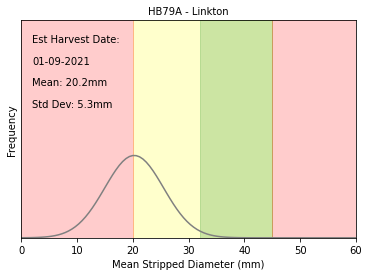

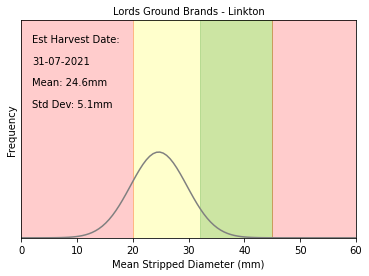

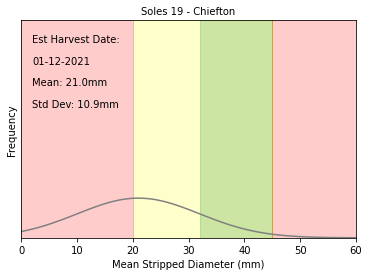

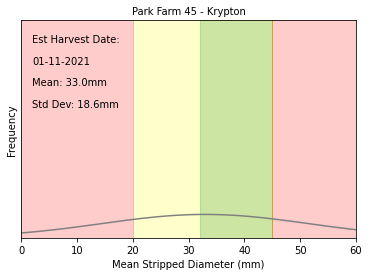

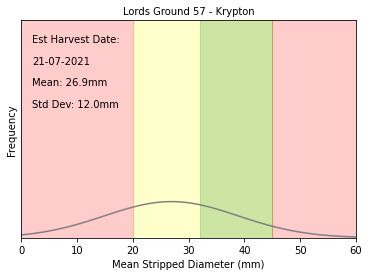

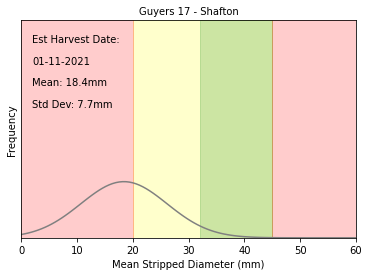

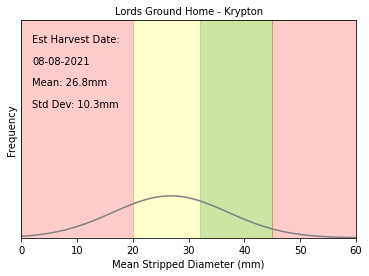

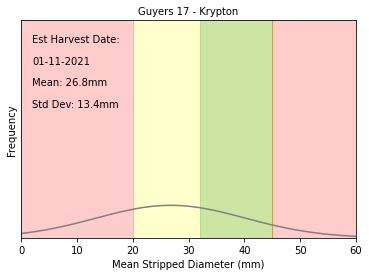

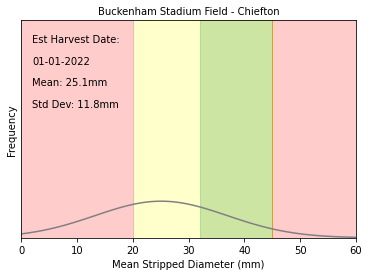

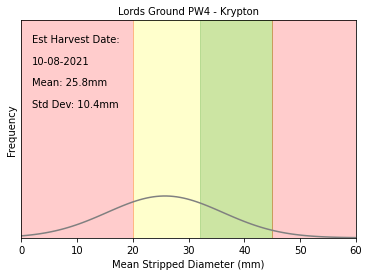

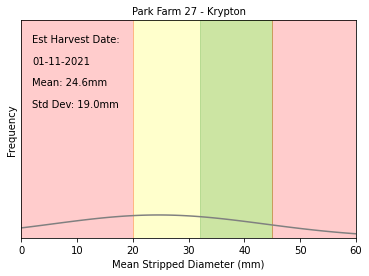

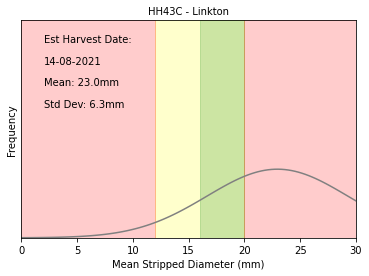

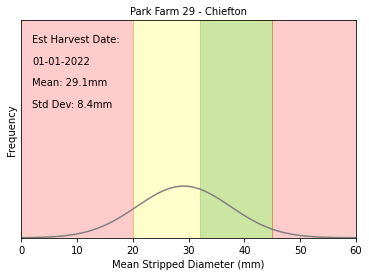

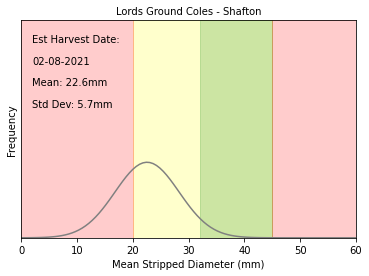

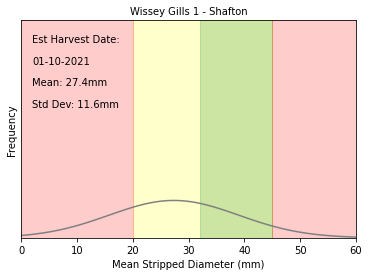

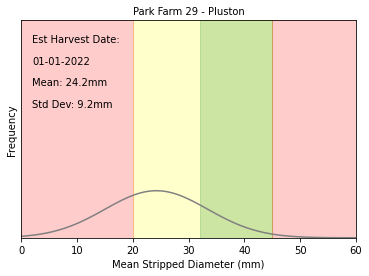

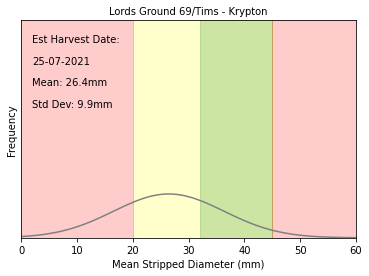

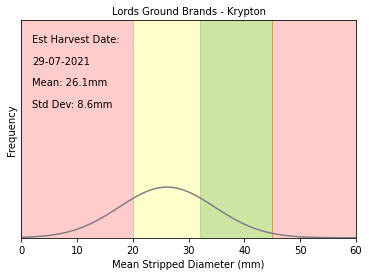

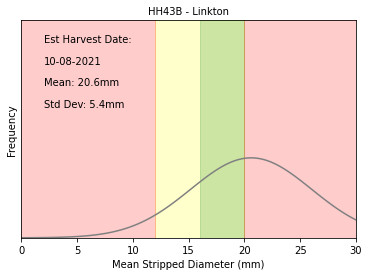

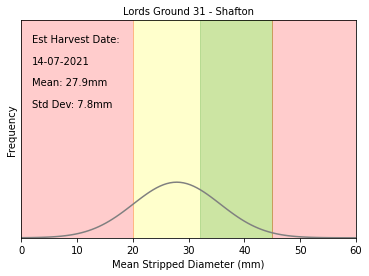

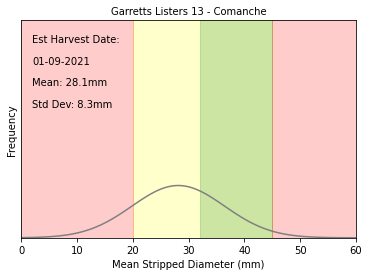

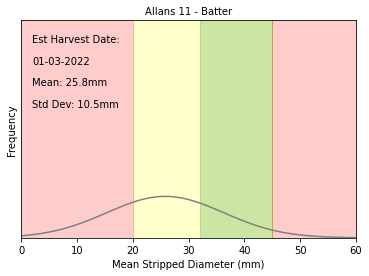

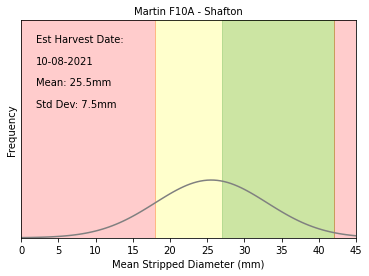

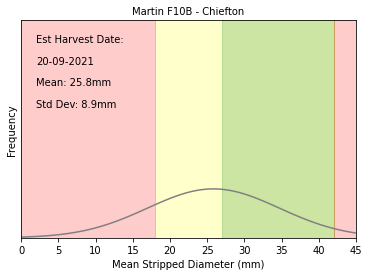

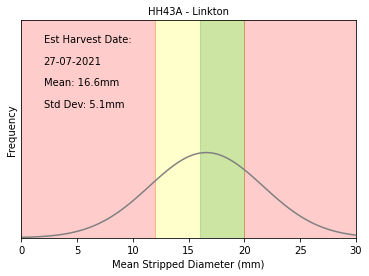

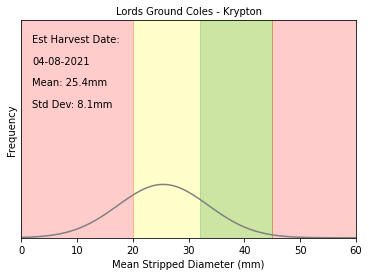

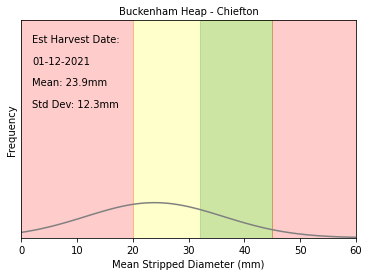

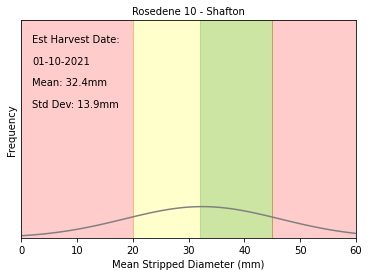

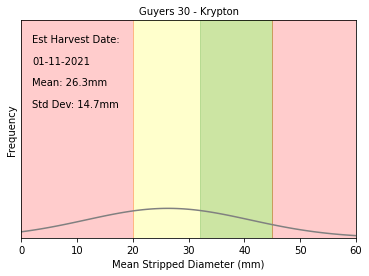

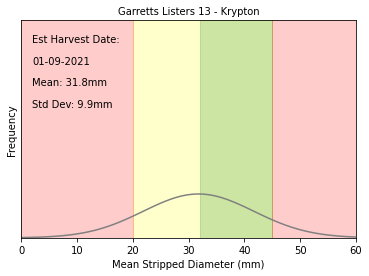

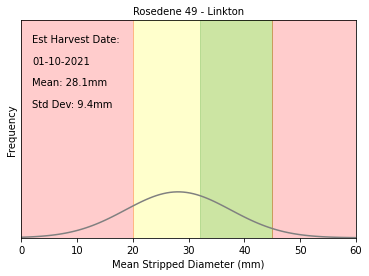

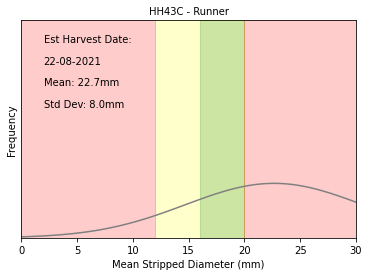

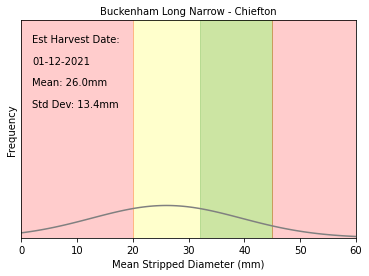

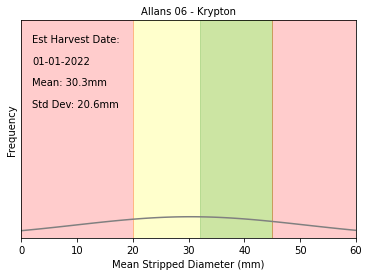

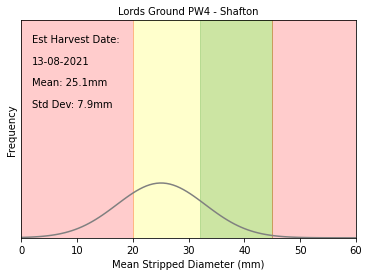

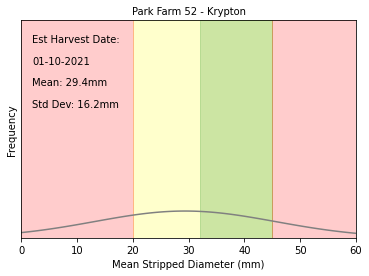

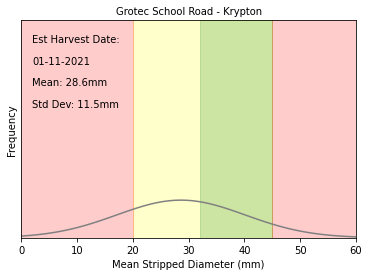

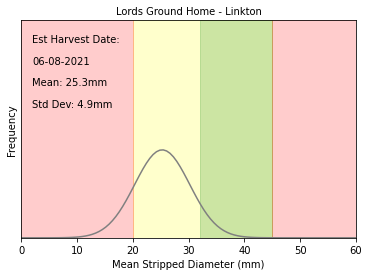

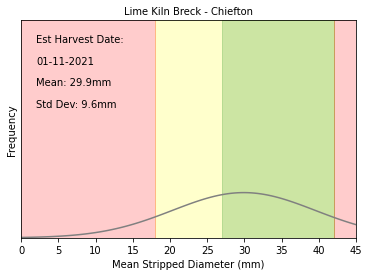

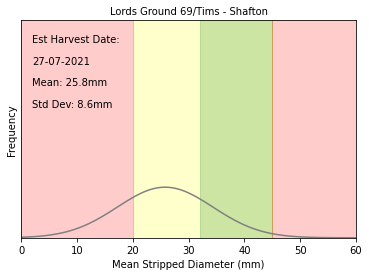

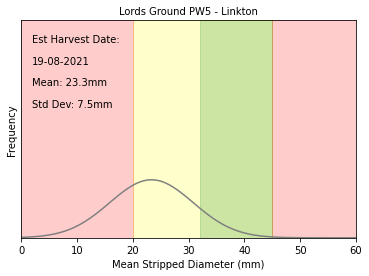

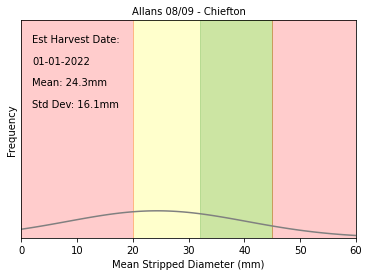

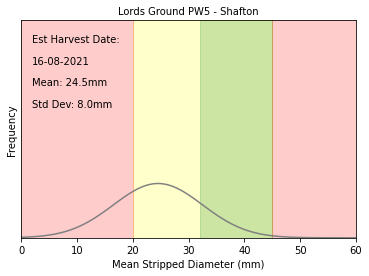

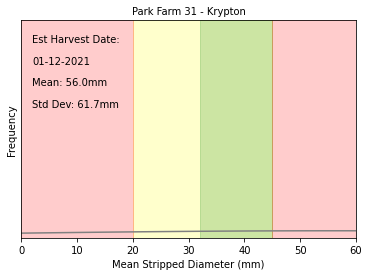

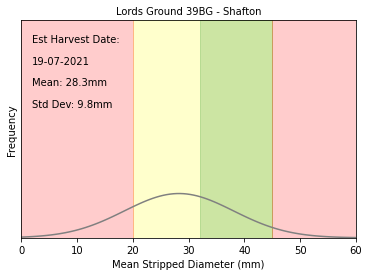

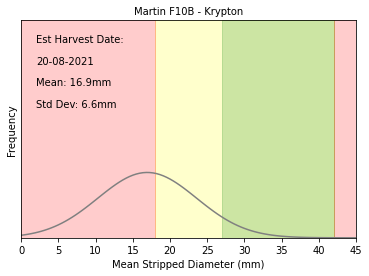

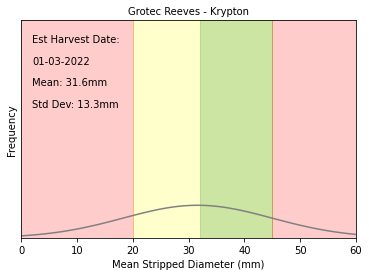

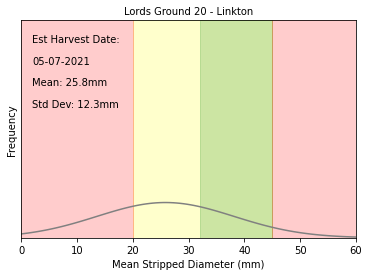

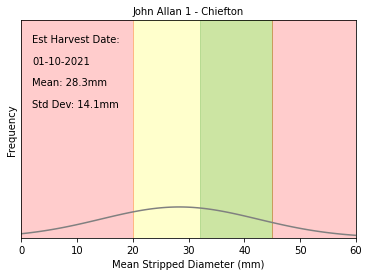

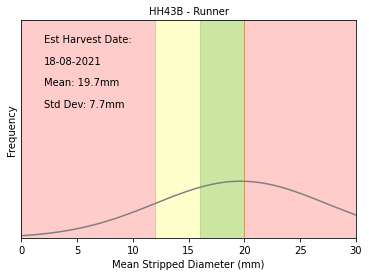

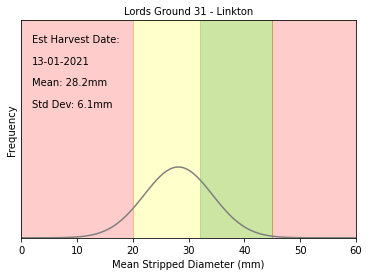

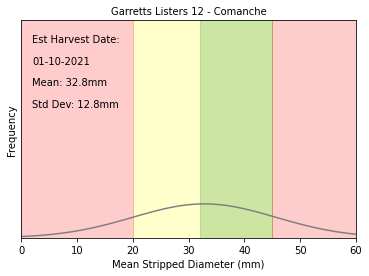

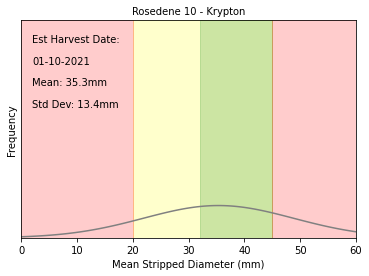

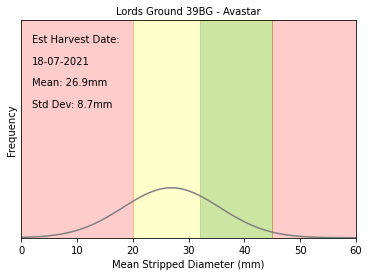

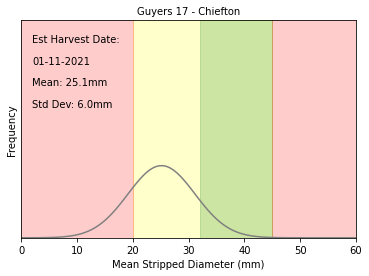

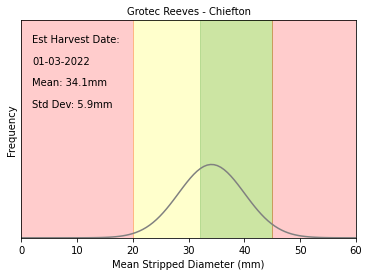

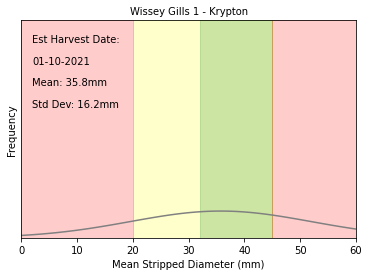

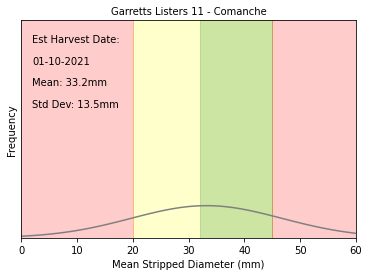

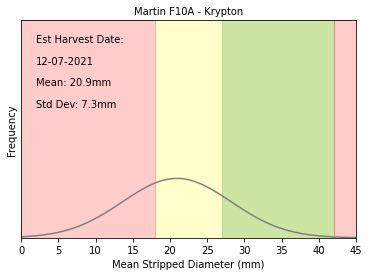

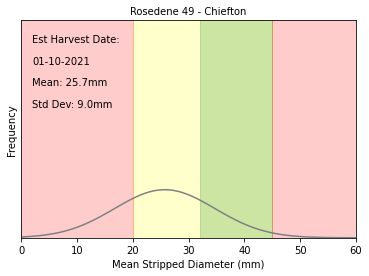

In [50]:
season = datetime(2021, 1, 1)
filt_zone_data = zone_data.loc[(zone_data['planting_date'] > season)]
field_variety_list = list(filt_zone_data['field_variety'])
field_variety_list = set(field_variety_list)
field_variety_list

for fv in field_variety_list:
    df = filt_zone_data.loc[(filt_zone_data['field_variety'] == fv)]
    df = df.reset_index(drop=True)
    inputs = mode(df['inputs'])
    
    if inputs == 'Baby':
        x_min = 0.0
        x_max = 30.0
        up_spec = 20
        low_spec = 12
        low_opt = 16
        
    elif inputs == 'Organic':
        x_min = 0.0
        x_max = 45.0
        up_spec = 42
        low_spec = 18
        low_opt = 27
        
    elif inputs == 'Conventional':
        x_min = 0.0
        x_max = 60.0
        up_spec = 45
        low_spec = 20
        low_opt = 32
        
    mean = df['est_mean_diameter'].mean()
    ###make this change!!
    ###Pooled Std. Deviation = Sqr.Root(Sum (std. Deviation squared)))
    pooled_std = 0
    for sd in df['est_std_dev_diameter']:
        pooled_std += sd**2
    pooled_std = mt.sqrt(pooled_std)

    x = np.linspace(x_min, x_max, 100)
    y = scipy.stats.norm.pdf(x,mean,pooled_std)
    c = 'grey'
    plt.plot(x,y, color=c)
    plt.grid()
    plt.xlim(x_min,x_max)
    plt.ylim(0,0.20)
    
    d = df.loc[0, 'est_harvest_date']
    d = d.date().strftime('%d-%m-%Y')
    
    plt.text(x=2, y=0.18, s='Est Harvest Date:')
    plt.text(x=2, y=0.16, s=d)
    plt.text(x=2, y=0.14, s=f'Mean: {mean:.1f}mm')
    plt.text(x=2, y=0.12, s=f'Std Dev: {pooled_std:.1f}mm')
    plt.grid(False)
    plt.axvspan(low_spec, up_spec, color='yellow', alpha=0.2)
    plt.axvspan(low_opt, up_spec, color='green', alpha=0.2)
    plt.axvspan(0, low_spec, color='red', alpha=0.2)
    plt.axvspan(up_spec, x_max, color='red', alpha=0.2)
    plt.title(f'{fv}',fontsize=10)
    
    new_fv = fv.replace('/', '-')

    plt.xlabel('Mean Stripped Diameter (mm)')
    plt.tick_params(left = False, labelleft = False)
    plt.ylabel('Frequency')
    if laptop == 'work':
        save_results_to = 'C:/Users/Tom/Documents/GitHub/AFL-Leek-Growth-Model/Distributions/'
        plt.savefig(f"{save_results_to}{new_fv} Population Distribution.png",dpi=600)
    plt.show()